In [ ]:
# 初始化顯示設置
%matplotlib widget

# 導入所需的庫
import json
import numpy as np
import numpy as np
# import pywt
import matplotlib.pyplot as plt
import json
from scipy.signal import find_peaks
from filterpy.kalman import ExtendedKalmanFilter
import os

def convertNewGaitToFloat(newGaitData):
    """
    將步態數據中的字符串值轉換為浮點數
    不轉換特定的屬性（如sensorTimeCode等）
    """
    needConvertList = ["sensorTimeCode", "greenLEDStatus", "Record", "DataType", "DataMode", "DataModeId", "Pain", "sensorTimeCode"]
    for inner_dict_key, inner_dict_value in newGaitData.items():
        if inner_dict_key in needConvertList:
            continue
        for key, value_list in inner_dict_value.items():
            for i in range(len(value_list)):
                value_list[i] = float(value_list[i])
    return newGaitData

def find_changes(lst, estCount):
    """
    尋找信號中的變化點
    lst: 輸入信號列表
    estCount: 估計的變化間隔
    返回變化點列表和錯誤索引字典
    """
    changes_1_to_0 = []
    changes_0_to_1 = []

    for i in range(len(lst) - 1):
        if lst[i] == 1 and lst[i + 1] == 0:
            changes_1_to_0.append(i)
        elif lst[i] == 0 and lst[i + 1] == 1:
            changes_0_to_1.append(i)

    if lst[-1] == 1:
        changes_1_to_0.append(len(lst) - 1)
    elif lst[-1] == 0:
        changes_0_to_1.append(len(lst) - 1)

    all_changes = changes_1_to_0 + changes_0_to_1
    all_changes.sort()

    errorIndex = {}
    for i in range(1, len(all_changes)):
        difference = all_changes[i] - all_changes[i - 1]
        if difference != estCount :
            errorIndex[str(all_changes[i-1])] = 60 - (all_changes[i] - all_changes[i - 1])

    return (all_changes, errorIndex)

def fixRightFootReverse(Gait_Dict):
    """
    修正右腳數據的反向問題
    將加速度、陀螺儀和磁力計數據反向
    """
    Gait_Dict["RightFootAcc"]['x'] = [-1*x for x in Gait_Dict["RightFootAcc"]['x']] #reverse
    Gait_Dict["RightFootAcc"]['y'] = [-1*x for x in Gait_Dict["RightFootAcc"]['y']]
    Gait_Dict["RightFootAcc"]['z'] = [-1*x for x in Gait_Dict["RightFootAcc"]['z']]
    Gait_Dict["RightFootGyro"]['x'] = [-1*x for x in Gait_Dict["RightFootGyro"]['x']]
    Gait_Dict["RightFootGyro"]['y'] = [-1*x for x in Gait_Dict["RightFootGyro"]['y']]
    Gait_Dict["RightFootGyro"]['z'] = [-1*x for x in Gait_Dict["RightFootGyro"]['z']]
    Gait_Dict["RightFootMag"]['x'] = [-1*x for x in Gait_Dict["RightFootMag"]['x']]
    Gait_Dict["RightFootMag"]['y'] = [-1*x for x in Gait_Dict["RightFootMag"]['y']]
    Gait_Dict["RightFootMag"]['z'] = [-1*x for x in Gait_Dict["RightFootMag"]['z']]
    return Gait_Dict

def fixLeftFootReverse(Gait_Dict):
    """
    修正左腳數據的反向問題
    將加速度、陀螺儀和磁力計數據反向
    """
    Gait_Dict["LeftFootAcc"]['x'] = [-1*x for x in Gait_Dict["LeftFootAcc"]['x']]
    Gait_Dict["LeftFootAcc"]['y'] = [-1*x for x in Gait_Dict["LeftFootAcc"]['y']]
    Gait_Dict["LeftFootAcc"]['z'] = [-1*x for x in Gait_Dict["LeftFootAcc"]['z']]
    Gait_Dict["LeftFootGyro"]['x'] = [-1*x for x in Gait_Dict["LeftFootGyro"]['x']]
    Gait_Dict["LeftFootGyro"]['y'] = [-1*x for x in Gait_Dict["LeftFootGyro"]['y']]
    Gait_Dict["LeftFootGyro"]['z'] = [-1*x for x in Gait_Dict["LeftFootGyro"]['z']]
    Gait_Dict["LeftFootMag"]['x'] = [-1*x for x in Gait_Dict["LeftFootMag"]['x']]
    Gait_Dict["LeftFootMag"]['y'] = [-1*x for x in Gait_Dict["LeftFootMag"]['y']]
    Gait_Dict["LeftFootMag"]['z'] = [-1*x for x in Gait_Dict["LeftFootMag"]['z']]
    return Gait_Dict

def AngleCheckUpsideDown(signal):
    """
    檢查信號是否需要上下翻轉
    通過計算正值和負值的比例來決定
    """
    # 計算大於0的元素數量
    np_signal = np.array(signal)
    positive_count = np.sum(np_signal >= 0)

    if positive_count < len(np_signal) / 2:
        print("T")
        print(positive_count," < ",len(np_signal) / 2)
        return True
    else:
        print("F")
        print(positive_count," >= ",len(np_signal) / 2)
        return False

# 步態分析系統主程式
這個程式用於分析步態數據，包含以下主要功能:
1. 資料預處理與過濾
2. 步態事件識別
3. 步態參數計算
4. 結果輸出與視覺化

請記得檢查 AngleCheckUpsideDown 函數的設定

In [ ]:
# 卡爾曼濾波處理函數
def myKalmenFilter(fileName):
    """
    對步態數據進行卡爾曼濾波處理
    1. 讀取JSON數據文件
    2. 轉換數據類型
    3. 處理LED狀態數據
    4. 進行數據方向修正
    5. 應用卡爾曼濾波
    """
    print('Start Filter KM Filter')
    Data = fileName
    with open(Data, 'r', encoding='utf-8-sig') as f:
        Gait_Dict = json.loads(f.read())

    print(len(Gait_Dict['LeftFootAcc']['x']))
    print(len(Gait_Dict['RightFootAcc']['x']))

    print("read file OK!")
    Gait_Dict = convertNewGaitToFloat(Gait_Dict)
    print("conv to float ok")

    # 檢查是否存在 isLedOn
    has_isLedOn = 'isLedOn' in Gait_Dict
    if has_isLedOn:
        # LED狀態數據處理
        Gait_Dict["isLedOn"]["LeftRedLED"][:59] = [0]*59
        LeftRedLEDData = Gait_Dict["isLedOn"]["LeftRedLED"]
        LeftGreenLEDData = Gait_Dict["isLedOn"]["LeftGreenLED"]
        RightRedLEDData = Gait_Dict["isLedOn"]["RightRedLED"]

        # 計算錯誤列表
        RedAll_changes, LeftErrorList = find_changes(LeftRedLEDData, 60)
        _, RightErrorList = find_changes(RightRedLEDData, 60)
    else:
        print("Error: isLedOn not found in Gait_Dict.")
        LeftErrorList = {}
        RightErrorList = {}

    # 數據方向修正
    if AngleCheckUpsideDown(Gait_Dict["LeftFootMag"]['y']):
        Gait_Dict = fixLeftFootReverse(Gait_Dict)
    if AngleCheckUpsideDown(Gait_Dict["RightFootMag"]['y']):
        Gait_Dict = fixRightFootReverse(Gait_Dict)

    print("Filter start!")
    # 對每個傳感器數據進行卡爾曼濾波
    for inner_dict_key, inner_dict_value in Gait_Dict.items():
        if inner_dict_key in ["sensorTimeCode", "isLedOn", "greenLEDStatus", "Record", "DataType", "DataMode", "DataModeId"]:
            continue

        # 選擇對應的錯誤列表
        if "Left" in inner_dict_key:
            ErrorList = LeftErrorList if has_isLedOn else {}
        elif "Right" in inner_dict_key:
            ErrorList = RightErrorList if has_isLedOn else {}
        else:
            ErrorList = {}

        # 對每個維度的數據進行濾波
        for key, value_list in inner_dict_value.items():
            thisTimeData = Gait_Dict[inner_dict_key][key]
            ekf = ExtendedKalmanFilter(dim_x=1, dim_z=1)
            ekf.x = np.array([thisTimeData[0]])
            ekf.F = np.array([[1]])
            ekf.P *= 1000.
            ekf.R = 5
            ekf.Q = 0.1
            Hx = lambda x: x
            HJacobian = lambda x: np.array([[1]])
            filtered_states = []
            missing_data_info = ErrorList

            # 逐點進行濾波
            for i, z in enumerate(thisTimeData[1:]):
                ekf.predict()
                if str(i) in missing_data_info:
                    for _ in range(missing_data_info[str(i)]):
                        ekf.predict()
                        filtered_states.append(ekf.x.copy())
                else:
                    ekf.update(z, HJacobian=HJacobian, Hx=Hx)
                    filtered_states.append(ekf.x.copy())

            Gait_Dict[inner_dict_key][key] = [state.tolist()[0] for state in filtered_states]

    return Gait_Dict

In [ ]:
# 設置檔案路徑和保存位置

# 記得檢查 AngleCheckUpsideDown 函數的設置

# 輸入檔案名稱

fileName = r"洪羽辰2分 步態.json"

# 設置結果保存資料夾

save_folder = r"C:\Users\trynd\OneDrive\Desktop\正常"

# 數據資料
接下來的步驟中，我們將進行以下操作：
1. 載入數據文件
2. 進行卡爾曼濾波處理
3. 進行資料預處理

In [ ]:
# 數據載入和卡爾曼濾波處理



import json



# 讀取原始數據

with open(fileName, 'r', encoding='utf-8-sig') as f: Ori_Gait_Dict = json.loads(f.read())



# 應用卡爾曼濾波

Gait_Dict = myKalmenFilter(fileName)

Start Filter KM Filter
14072
14356
read file OK!
conv to float ok
T
5333  <  7036.0
T
4592  <  7178.0
Filter start!


In [ ]:
# 檢查所有數據序列的長度
# 確保所有數據具有相同的長度，避免後續處理出錯

# 獲取所有需要分析的變數數據
Gait_Dict_variables = [
    Gait_Dict['LeftFootAcc']['x'], Gait_Dict['LeftFootAcc']['y'], Gait_Dict['LeftFootAcc']['z'],
    Gait_Dict['RightFootAcc']['x'], Gait_Dict['RightFootAcc']['y'], Gait_Dict['RightFootAcc']['z'],
    Gait_Dict['LeftFootMag']['y'], Gait_Dict['RightFootMag']['y'],
    Gait_Dict['LeftFootGyro']['x'], Gait_Dict['LeftFootGyro']['y'], Gait_Dict['LeftFootGyro']['z'],
    Gait_Dict['RightFootGyro']['x'], Gait_Dict['RightFootGyro']['y'], Gait_Dict['RightFootGyro']['z']
]

# 計算最短序列長度，確保後續處理使用相同長度的數據
Gait_Dict_variables_min_len = min(len(data) for data in Gait_Dict_variables)

print(f"最短長度為: {Gait_Dict_variables_min_len}")

最短長度為: 14464


# 手動翻轉數據處理
這一部分用於處理可能需要手動調整的數據翻轉操作，確保數據的正確方向。
後續步驟將進行：
1. 數據切片和預處理
2. 信號濾波
3. 特徵提取

In [ ]:
# 數據切片和預處理
# 對所有傳感器數據進行統一的切片處理

# 設定切片範圍
split_start = None  # 起始索引
split_end = Gait_Dict_variables_min_len  # 結束索引，使用最短序列長度

# 定義切片函數
def slice_array(data, start, end):
    """
    對數據進行切片處理
    data: 輸入數據
    start: 起始索引
    end: 結束索引
    """
    return np.array(data[start:end]) if data is not None else None

# 處理左腳加速度數據
LeftAccX = slice_array(Gait_Dict['LeftFootAcc']['x'], split_start, split_end)
LeftAccY = slice_array(Gait_Dict['LeftFootAcc']['y'], split_start, split_end) * 1
LeftAccZ = slice_array(Gait_Dict['LeftFootAcc']['z'], split_start, split_end) * 1

# 處理右腳加速度數據
RightAccX = slice_array(Gait_Dict['RightFootAcc']['x'], split_start, split_end)
RightAccY = slice_array(Gait_Dict['RightFootAcc']['y'], split_start, split_end)
RightAccZ = slice_array(Gait_Dict['RightFootAcc']['z'], split_start, split_end)

# 處理磁力計數據
LeftFootMagY = slice_array(Gait_Dict['LeftFootMag']['y'], split_start, split_end)
RightFootMagY = slice_array(Gait_Dict['RightFootMag']['y'], split_start, split_end)

# 處理陀螺儀數據
LeftGyroX = slice_array(Gait_Dict['LeftFootGyro']['x'], split_start, split_end) * -1
LeftGyroY = slice_array(Gait_Dict['LeftFootGyro']['y'], split_start, split_end) * -1
LeftGyroZ = slice_array(Gait_Dict['LeftFootGyro']['z'], split_start, split_end) * -1

RightGyroX = slice_array(Gait_Dict['RightFootGyro']['x'], split_start, split_end)
RightGyroY = slice_array(Gait_Dict['RightFootGyro']['y'], split_start, split_end)
RightGyroZ = slice_array(Gait_Dict['RightFootGyro']['z'], split_start, split_end)

# 初始化bug修正標記
bugFixed = False

In [ ]:
# 比較原始數據和處理後數據的長度
# 檢查數據處理前後的一致性

# 檢查左腳加速度X軸數據
originLeftAccX = np.array(Ori_Gait_Dict['LeftFootAcc']['x'])
print("originLeftAccX:", len(originLeftAccX))
print("LeftAccX:", len(LeftAccX))
print("RightAccX:", len(RightAccX))

# 檢查左腳磁力計Y軸數據
originLeftMagY = np.array(Ori_Gait_Dict['LeftFootMag']['y'])
print("originLeftMagY:", len(originLeftMagY))

originLeftAccX: 14072
LeftAccX: 14464
RightAccX: 14464
originLeftMagY: 14072


ori_right_accX: 14356
ori_left_accX: 14072


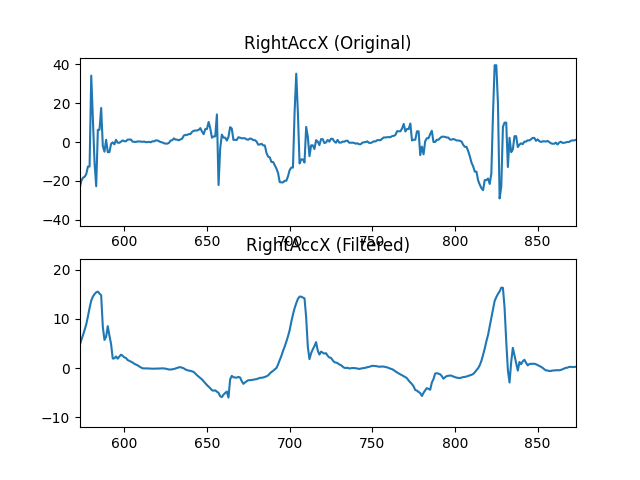

In [ ]:
# 視覺化比較卡爾曼濾波前後的數據差異

# 計算數據長度
data_length = (len(LeftAccX) + len(RightAccX))/20

# 獲取原始數據
ori_right_accX = np.array(Ori_Gait_Dict['RightFootAcc']['x'].copy()).astype(np.float64)
ori_left_accX = np.array(Ori_Gait_Dict['LeftFootAcc']['x'].copy()).astype(np.float64)

# 輸出數據長度
print("ori_right_accX:", len(ori_right_accX))
print("ori_left_accX:", len(ori_left_accX))

# 創建圖表比較濾波前後的右腳加速度X軸數據
plt.figure()
plt.subplot(2,1,1)
plt.plot(ori_right_accX)
plt.title('RightAccX (Original)')
plt.xlim(data_length/2-150,data_length/2+150)

plt.subplot(2,1,2)
plt.plot(RightAccX)
plt.title('RightAccX (Filtered)')
plt.xlim(data_length/2-150,data_length/2+150)
plt.show()

Plot Ori

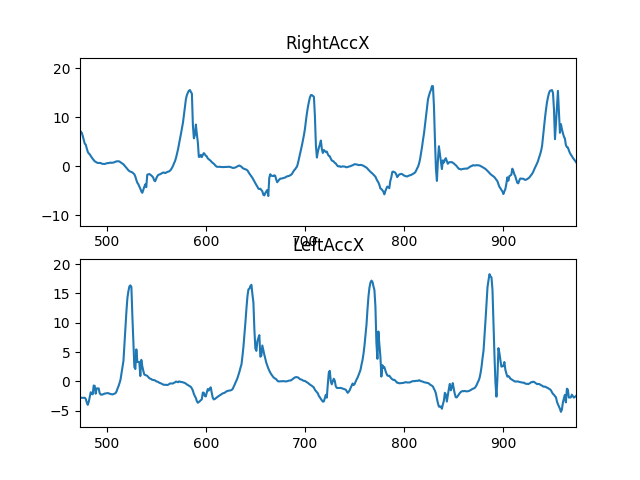

In [ ]:
# 比較左右腳加速度X軸數據
# 創建圖表顯示左右腳的加速度數據比較

plt.figure()
# 顯示右腳加速度
plt.subplot(2,1,1)
plt.plot(RightAccX)
plt.title('RightAccX')
plt.xlim(data_length/2-250,data_length/2+250)

# 顯示左腳加速度
plt.subplot(2,1,2)
plt.plot(LeftAccX)
plt.title('LeftAccX')
plt.xlim(data_length/2-250,data_length/2+250)
plt.show()

In [ ]:
# 定義FFT分析函數
def plot_fft(signal, sample_rate = 120):
    """
    進行快速傅立葉變換分析並繪製頻譜圖

    Parameters:
    signal: 輸入信號
    sample_rate: 採樣率，默認為120Hz
    """
    # 計算 FFT
    N = len(signal)
    fft_values = np.fft.fft(signal)
    freqs = np.fft.fftfreq(N, 1/sample_rate)

    # 取絕對值並歸一化
    fft_magnitude = np.abs(fft_values) / N

    # 只保留正頻率部分
    positive_freqs = freqs[:N//2]
    positive_magnitude = fft_magnitude[:N//2]

    # 繪製頻譜圖
    plt.figure(figsize=(10, 5))
    plt.plot(positive_freqs, positive_magnitude)
    plt.title('FFT of Signal')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.show()

In [ ]:
# plot_fft(ori_right_accX)
# plot_fft(RightAccX)

In [ ]:
# 定義巴特沃斯低通濾波器函數
from scipy.signal import butter, filtfilt

def butter_lowpass_filter(data, cutoff, fs=120, order=2):
    """
    應用巴特沃斯低通濾波器

    Parameters:
    data: 輸入信號
    cutoff: 截止頻率
    fs: 採樣率，默認120Hz
    order: 濾波器階數，默認2階
    """
    nyq = 0.5 * fs  # 奈奎斯特頻率
    normal_cutoff = cutoff / nyq
    # 獲取濾波器係數
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

In [ ]:
# 對加速度信號進行低通濾波處理
# 使用8Hz的截止頻率

# 處理左腳加速度數據
LeftAccX = butter_lowpass_filter(LeftAccX,8)
# leftAccY = butter_lowpass_filter(leftAccY,10)
# leftAccZ = butter_lowpass_filter(leftAccZ,10)

# 處理右腳加速度數據
RightAccX = butter_lowpass_filter(RightAccX,8)
# RightAccY = butter_lowpass_filter(RightAccY,10)
# RightAccZ = butter_lowpass_filter(RightAccZ,10)

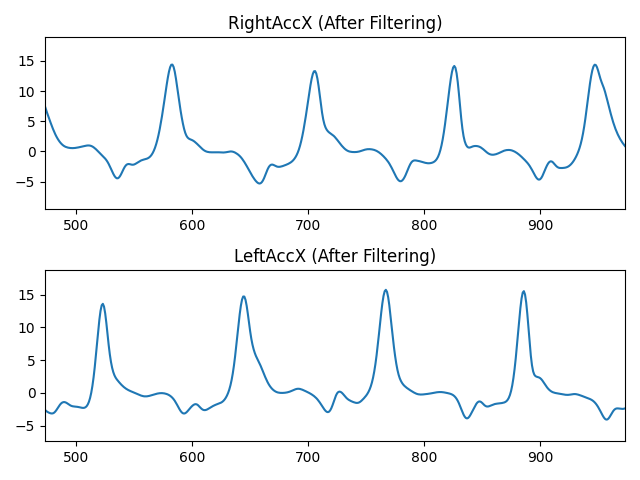

In [ ]:
# 視覺化展示濾波後的左右腳加速度數據
plt.figure()

# 顯示右腳加速度
plt.subplot(2,1,1)
plt.plot(RightAccX)
plt.title('RightAccX (After Filtering)')
plt.xlim(data_length/2-250,data_length/2+250)

# 顯示左腳加速度
plt.subplot(2,1,2)
plt.plot(LeftAccX)
plt.title('LeftAccX (After Filtering)')
plt.xlim(data_length/2-250,data_length/2+250)

plt.tight_layout()
plt.show()

# 總體數據可視化檢查
這一部分將展示所有關鍵數據的可視化結果，包括：
1. 左右腳加速度數據
2. 腳部角度數據
3. 陀螺儀數據
用於確認數據處理的正確性和完整性

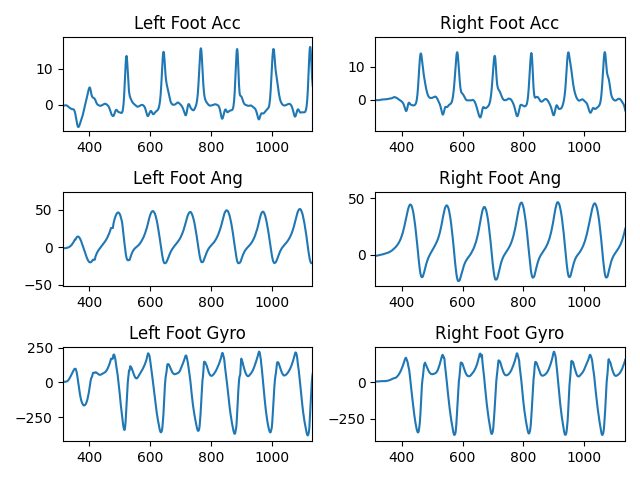

In [ ]:
# 顯示所有關鍵步態參數的可視化圖表
# 包括加速度、角度和陀螺儀數據

# 設定顯示範圍
rangeStart = data_length/2-410
rangeStop = data_length/2+410

# 創建子圖
fig, ax = plt.subplots(3,2)

# 左右腳加速度比較
ax[0,0].set_title('Left Foot Acc')
ax[0,0].plot(LeftAccX)
ax[0,0].set_xlim([rangeStart,rangeStop])

ax[0,1].set_title('Right Foot Acc')
ax[0,1].plot(RightAccX)
ax[0,1].set_xlim([rangeStart,rangeStop])

# 左右腳角度比較
ax[1,0].set_title('Left Foot Ang')
ax[1,0].plot(LeftFootMagY)
ax[1,0].set_xlim([rangeStart,rangeStop])

ax[1,1].set_title('Right Foot Ang')
ax[1,1].plot(RightFootMagY)
ax[1,1].set_xlim([rangeStart,rangeStop])

# 左右腳陀螺儀比較
ax[2,0].set_title('Left Foot Gyro')
ax[2,0].plot(LeftGyroZ)
ax[2,0].set_xlim([rangeStart,rangeStop])

ax[2,1].set_title('Right Foot Gyro')
ax[2,1].plot(RightGyroZ)
ax[2,1].set_xlim([rangeStart,rangeStop])

plt.tight_layout()
plt.show()

# 初始接觸點檢測 (Initial Contact Detection)
這一部分將進行：
1. 步態週期中初始接觸點的識別
2. 使用峰值檢測算法尋找關鍵事件點
3. 計算相關步態參數

In [ ]:
# 分析加速度信號的正負值分布
# 用於確認信號的偏移情況

# 計算左腳加速度的正負值總和
left_pos_sum = np.sum(LeftAccX[LeftAccX > 0])
left_neg_sum = np.sum(LeftAccX[LeftAccX < 0])

# 計算右腳加速度的正負值總和
right_pos_sum = np.sum(RightAccX[RightAccX > 0])
right_neg_sum = np.sum(RightAccX[RightAccX < 0])

# 輸出分析結果
print(f"LeftAccX > 0 sum: {left_pos_sum}, LeftAccX < 0 sum: {left_neg_sum}")
print(f"RightAccX > 0 sum: {right_pos_sum}, RightAccX < 0 sum: {right_neg_sum}")

LeftAccX > 0 sum: 24561.720694215197, LeftAccX < 0 sum: -10075.454248718905
RightAccX > 0 sum: 24550.723757301326, RightAccX < 0 sum: -11089.269815262827


In [ ]:
# 定義初始接觸點檢測函數
def findInitialContact(AccSingal):
    """
    檢測步態中的初始接觸點
    使用峰值檢測算法，設定最小間距和突出度
    """
    initContactPeaks,_ = find_peaks(AccSingal , distance=70,prominence=5)
    return initContactPeaks

# 檢測左右腳的初始接觸點
leftFootInitialContact = findInitialContact(LeftAccX)
rightFootInitialContact = findInitialContact(RightAccX)

# 檢測負方向的初始接觸點
negativeLeftFootInitialContact = findInitialContact(-LeftAccX)
negativeRightFootInitialContact = findInitialContact(-RightAccX)

# 計算並比較正負方向的平均值
left_mean = np.mean(LeftAccX[leftFootInitialContact])
right_mean = np.mean(RightAccX[rightFootInitialContact])
negative_left_mean = np.mean(-LeftAccX[negativeLeftFootInitialContact])
negative_right_mean = np.mean(-RightAccX[negativeRightFootInitialContact])

# 根據均值比較結果進行信號翻轉
if left_mean < negative_left_mean:
    # 翻轉左腳所有數據
    LeftAccX *= -1
    LeftAccY *= -1
    LeftAccZ *= -1
    LeftFootMagY *= -1
    LeftGyroX *= -1
    LeftGyroY *= -1
    LeftGyroZ *= -1

if right_mean < negative_right_mean:
    # 翻轉右腳所有數據
    RightAccX *= -1
    RightAccY *= -1
    RightAccZ *= -1
    RightFootMagY *= -1
    RightGyroX *= -1
    RightGyroY *= -1
    RightGyroZ *= -1

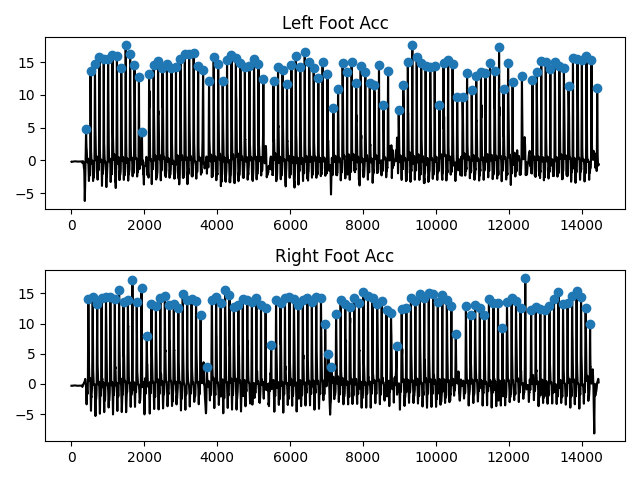

In [ ]:
# 視覺化展示初始接觸點檢測結果

# 重新檢測初始接觸點
leftFootInitialContact = findInitialContact(LeftAccX)
rightFootInitialContact = findInitialContact(RightAccX)

# 創建圖表
fig, ax = plt.subplots(2,1)

# 繪製左腳數據和檢測點
ax[0].set_title('Left Foot Acc')
ax[0].plot(LeftAccX,color='black')
ax[0].plot(leftFootInitialContact,LeftAccX[leftFootInitialContact],'o')

# 繪製右腳數據和檢測點
ax[1].set_title('Right Foot Acc')
ax[1].plot(RightAccX,color='black')
ax[1].plot(rightFootInitialContact,RightAccX[rightFootInitialContact],'o')

# 保存圖表
new_image_path = f"{save_folder}\\{os.path.splitext(os.path.basename(fileName))[0]}\\{os.path.splitext(os.path.basename(fileName))[0]}_Foot_Acc.jpg"
# 確保目標資料夾存在
os.makedirs(os.path.dirname(new_image_path), exist_ok=True)
plt.savefig(new_image_path)

plt.tight_layout()
plt.show()

# 轉向點檢測 (Turn Point Detection)
這一部分主要用於：
1. 識別步態中的轉向點
2. 使用陀螺儀數據進行轉向分析
3. 計算相關轉向參數

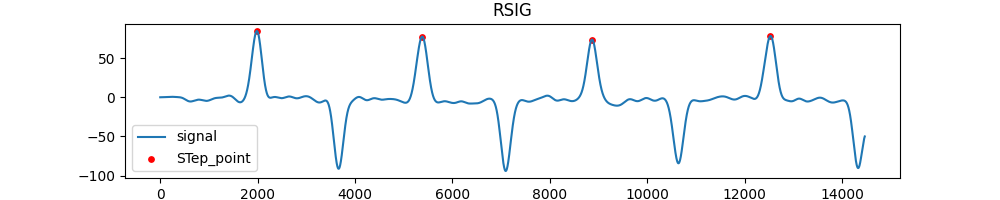

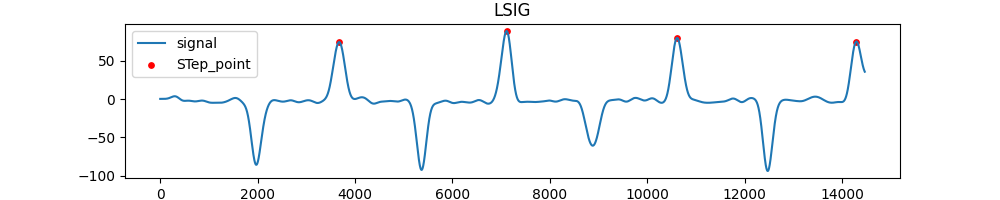

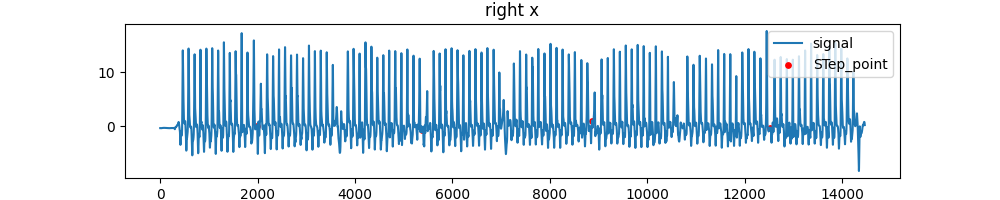

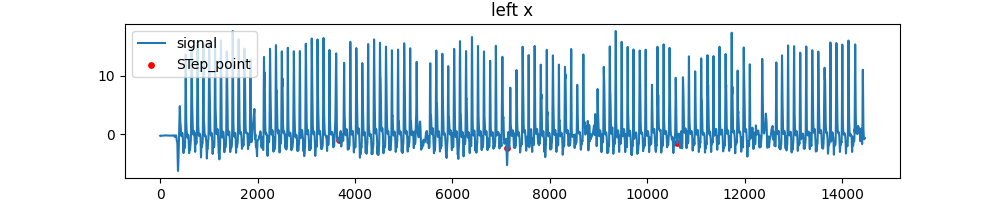

In [ ]:
# 處理陀螺儀數據以檢測轉向

# 均值濾波處理 - 用於轉向檢測
# 對LeftGyroY和RightGyroY進行六階均值濾波
from package.filter import mean_filter_turn
RSIG = mean_filter_turn(RightGyroY*-1,order=6,kernel_size=121)
LSIG = mean_filter_turn(LeftGyroY,order=6,kernel_size=121)

# 使用Savitzky-Golay濾波進行額外的平滑處理
from package.filter import SG_filter
RSIG = SG_filter(RSIG,window_length=121)
RSIG = SG_filter(RSIG,window_length=121)

# 特徵檢測
from package.feature import *
rp = FindPeaks(sig=RSIG,width=40,height=20)
lp = FindPeaks(sig=LSIG,width=40,height=20)

# 視覺化展示結果
from package.signaldisplay import sigpeaks
# 顯示右腳陀螺儀信號和檢測到的峰值
sigpeaks(sig=RSIG,Peaks=rp,title='RSIG',size=(10, 2))
# 顯示左腳陀螺儀信號和檢測到的峰值
sigpeaks(sig=LSIG,Peaks=lp,title='LSIG',size=(10, 2))
# 顯示右腳加速度X軸和檢測到的峰值
sigpeaks(sig=RightAccX,Peaks=rp,title='right x',size=(10, 2))
# 顯示左腳加速度X軸和檢測到的峰值
sigpeaks(sig=LeftAccX,Peaks=lp,title='left x',size=(10, 2))

In [ ]:
len(rightFootInitialContact)

110

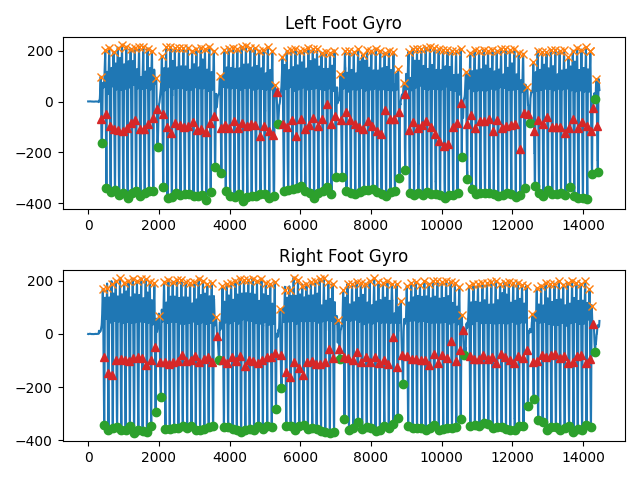

In [ ]:
# 定義離地點檢測函數
def findToeOffPeaks(GyroSignal):
    """
    檢測步態中的離地點(Toe-Off)和相關事件

    參數:
    GyroSignal: 陀螺儀信號

    返回:
    toeOffPeaks: 離地點時間點
    tibiaVerticalPeaks: 脛骨垂直時間點
    feetAdjcentPeaks: 足部相鄰時間點
    """
    # 檢測所有峰值和谷值
    allPeaks, _ =  find_peaks(GyroSignal, height= 50)
    allVallyPeaks, _ = tibiaVerticalPeaks, _ = find_peaks(GyroSignal*-1, distance=70 , prominence=20)

    toeOffPeaks = []
    feetAdjcentPeaks = []
    # 遍歷所有谷值，尋找相關事件點
    for valley in allVallyPeaks:
        gyr_z_peaks = [peak for peak in allPeaks if peak < valley]
        if gyr_z_peaks:  # 檢查序列是否為空
            toeOffPeaks.append(max(gyr_z_peaks))
            calcFeetAdjPeaks = ((valley - max(gyr_z_peaks)) / 2) + max(gyr_z_peaks)
            feetAdjcentPeaks.append(int(calcFeetAdjPeaks))
    return toeOffPeaks,tibiaVerticalPeaks,feetAdjcentPeaks

# 檢測左右腳的離地點和相關事件
leftToeOffPeaks, leftTibiaVertical,leftFeetAdjcentPeaks = findToeOffPeaks(LeftGyroZ)
rightToeOffPeaks, rightTibiaVertical,rightFeetAdjcentPeaks = findToeOffPeaks(RightGyroZ)

# 創建圖表展示檢測結果
fig, ax = plt.subplots(2,1)

# 繪製左腳陀螺儀數據和檢測點
ax[0].set_title('Left Foot Gyro')
ax[0].plot(LeftGyroZ)
ax[0].plot(leftToeOffPeaks,LeftGyroZ[leftToeOffPeaks],'x')  # 離地點
ax[0].plot(leftTibiaVertical,LeftGyroZ[leftTibiaVertical],'o')  # 脛骨垂直點
ax[0].plot(leftFeetAdjcentPeaks,LeftGyroZ[leftFeetAdjcentPeaks],'^')  # 足部相鄰點

# 繪製右腳陀螺儀數據和檢測點
ax[1].set_title('Right Foot Gyro')
ax[1].plot(RightGyroZ)
ax[1].plot(rightToeOffPeaks,RightGyroZ[rightToeOffPeaks],'x')  # 離地點
ax[1].plot(rightTibiaVertical,RightGyroZ[rightTibiaVertical],'o')  # 脛骨垂直點
ax[1].plot(rightFeetAdjcentPeaks,RightGyroZ[rightFeetAdjcentPeaks],'^')  # 足部相鄰點

plt.tight_layout()
plt.show()

issue : Heel off / Opp IC


(473.20000000000005, 973.2)

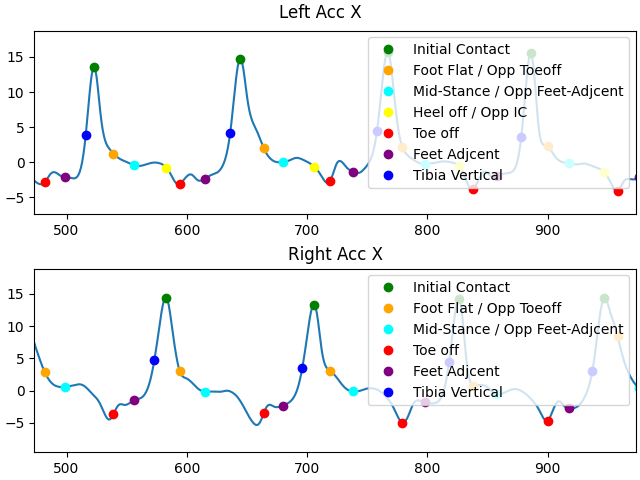

In [ ]:
# 綜合展示所有步態事件的視覺化

plt.figure(layout = 'constrained')

# 左腳加速度X軸數據及事件標記
plt.subplot(211)
plt.suptitle('Left Acc X')
plt.plot(LeftAccX)
plt.plot(leftFootInitialContact, LeftAccX[leftFootInitialContact], "o", color='green', label = 'Initial Contact')
plt.plot(rightToeOffPeaks,LeftAccX[rightToeOffPeaks], "o", color='orange',label = "Foot Flat / Opp Toeoff")
plt.plot(rightFeetAdjcentPeaks,LeftAccX[rightFeetAdjcentPeaks], "o", color='cyan', label = 'Mid-Stance / Opp Feet-Adjcent')
plt.plot(rightFootInitialContact[:-1], LeftAccX[rightFootInitialContact[:-1]], "o", color='yellow', label = "Heel off / Opp IC")
plt.plot(leftToeOffPeaks,LeftAccX[leftToeOffPeaks], "o", color='red', label="Toe off")
plt.plot(leftFeetAdjcentPeaks,LeftAccX[leftFeetAdjcentPeaks], "o", color='purple', label = 'Feet Adjcent')
plt.plot(leftTibiaVertical, LeftAccX[leftTibiaVertical], "o", color='blue', label = "Tibia Vertical")
plt.legend(loc = 'upper right')
plt.xlim(data_length/2-250,data_length/2+250)

# 右腳加速度X軸數據及事件標記
plt.subplot(212)
plt.title('Right Acc X')
plt.plot(RightAccX)
plt.plot(rightFootInitialContact, RightAccX[rightFootInitialContact], "o", color='green', label = 'Initial Contact')
plt.plot(leftToeOffPeaks,RightAccX[leftToeOffPeaks], "o", color='orange',label = "Foot Flat / Opp Toeoff")
plt.plot(leftFeetAdjcentPeaks,RightAccX[leftFeetAdjcentPeaks], "o", color='cyan', label = 'Mid-Stance / Opp Feet-Adjcent')
if(bugFixed == True):
    plt.plot(leftFootInitialContact, RightAccX[leftFootInitialContact], "o", color='yellow', label = "Heel off / Opp IC")
else:
    print("issue : Heel off / Opp IC")
plt.plot(rightToeOffPeaks,RightAccX[rightToeOffPeaks], "o", color='red', label="Toe off")
plt.plot(rightFeetAdjcentPeaks,RightAccX[rightFeetAdjcentPeaks], "o", color='purple', label = 'Feet Adjcent')
plt.plot(rightTibiaVertical, RightAccX[rightTibiaVertical], "o", color='blue', label = "Tibia Vertical")
plt.legend(loc = 'upper right')
plt.xlim(data_length/2-250,data_length/2+250)

In [ ]:
print("================================================================")
print(f"{leftFootInitialContact}")
print(f"{rightToeOffPeaks}")

[  402   523   644   767   886  1005  1126  1247  1366  1488  1609  1728
  1851  1933  2130  2254  2376  2496  2619  2743  2867  2989  3110  3229
  3352  3475  3611  3775  3902  4025  4148  4268  4390  4511  4634  4757
  4882  5008  5131  5264  5543  5667  5791  5912  6034  6154  6278  6400
  6523  6646  6772  6890  7024  7186  7314  7439  7563  7686  7812  7935
  8061  8184  8309  8436  8560  8686  8978  9105  9228  9351  9472  9595
  9716  9843  9965 10095 10208 10334 10456 10582 10730 10853 10981 11105
 11234 11358 11481 11606 11731 11853 11978 12103 12358 12647 12764 12888
 13012 13138 13262 13385 13509 13638 13758 13880 14002 14128 14266 14423]
[np.int64(414), np.int64(539), np.int64(664), np.int64(779), np.int64(900), np.int64(1019), np.int64(1140), np.int64(1261), np.int64(1379), np.int64(1501), np.int64(1627), np.int64(1744), np.int64(1871), np.int64(2008), np.int64(2146), np.int64(2269), np.int64(2391), np.int64(2513), np.int64(2637), np.int64(2760), np.int64(2883), np.int64(3

In [ ]:
# 定義步態週期百分比計算函數
def calculate_percentage(events):
    """
    計算步態週期中各個事件所占的百分比

    參數:
    events: 包含各個步態事件時間點的字典

    返回:
    average_percentages: 各事件的平均百分比
    first_loading_response: 第一個加載響應時間點
    last_terminal_swing: 最後一個終端擺動時間點
    """
    # 將事件按照步態週期分組
    gait_cycles = [events['Loading Response'][i:i+2] for i in range(len(events['Loading Response'])-1)]

    # 初始化百分比字典
    percentages = {event: [] for event in events.keys()}
    event_order = list(events.keys())
    first_loading_response = None
    last_terminal_swing = None

    # 計算每個週期內各事件的百分比
    for cycle_num, cycle in enumerate(gait_cycles, start=1):
        cycle_length = cycle[1] - cycle[0]
        temp_percentages = {event: [] for event in events.keys()}

        # 處理每個事件
        for i, event in enumerate(event_order):
            cycle_events = [idx for idx in events[event] if cycle[0] <= idx < cycle[1]]
            if len(cycle_events) != 1:
                break
            event_idx = cycle_events[0]

            # 計算下一個事件的位置
            if i == len(event_order) - 1:
                next_event_idx = cycle[1]
            else:
                next_event = event_order[i+1]
                next_cycle_events = [idx for idx in events[next_event] if cycle[0] <= idx < cycle[1]]
                if len(next_cycle_events) != 1 or next_cycle_events[0] < event_idx:
                    break
                next_event_idx = max(next_cycle_events, key=lambda x: abs(x - event_idx))

            # 計算百分比
            percentage = (next_event_idx - event_idx) / cycle_length * 100
            temp_percentages[event].append(percentage)
        else:
            # 將臨時百分比加入總體結果
            for event in event_order:
                percentages[event].extend(temp_percentages[event])
            if first_loading_response is None:
                first_loading_response = events['Loading Response'][cycle_num-1]

    # 計算平均百分比
    average_percentages = {event: np.mean(values) for event, values in percentages.items() if values}

    # 分別計算支撐期和擺動期的總百分比
    stance_phase_events = event_order[:event_order.index('Pre-Swing')+1]
    swing_phase_events = event_order[event_order.index('Initial Swing'):event_order.index('Terminal Swing')+1]

    average_percentages['Stance Phase'] = sum(average_percentages[event] for event in stance_phase_events)
    average_percentages['Swing Phase'] = sum(average_percentages[event] for event in swing_phase_events)
    last_terminal_swing = events['Terminal Swing'][-1]

    return average_percentages, first_loading_response, last_terminal_swing


def three_point_differentiation(data, h):
    """
    使用三點法計算數據的導數

    參數:
    data: 輸入數據
    h: 時間步長
    """
    n = len(data)
    derivative = [0] * n

    # 中心差分
    for i in range(1, n - 1):
        derivative[i] = (data[i + 1] - data[i - 1]) / (2 * h)

    # 前向差分（第一點）
    derivative[0] = (data[1] - data[0]) / h

    # 後向差分（最後一點）
    derivative[-1] = (data[-1] - data[-2]) / h

    return derivative


def calculate_gait_metrics(events,first_loading_response, last_terminal_swing):
    """
    計算步態指標

    計算：步數、總行走時間、步頻、步態週期間隔等
    """
    # 計算步數
    step_count = len(events['Loading Response'])
    print(f"Step Count: {step_count}")

    # 計算總行走時間
    total_time = (last_terminal_swing - first_loading_response) / 120
    print(f"Total Walking Time: {total_time:.0f} seconds")

    # 計算步頻
    Cadence = step_count / (total_time / 60)
    print(f"Cadence: {Cadence:.2f} steps/minute\n")

    # 計算步態週期間隔
    gci = np.diff(leftFootInitialContact)
    print(f"Gait Cycle Interval: {np.mean(gci)/120:.2f} seconds, datapoints: {np.mean(gci).astype(int)}")

    # 計算每步的步頻
    cadence_per_stride = gci / 120
    print(f"Cadence per Stride avg: {np.mean(cadence_per_stride)}")

    # 計算步頻變化率
    delta_cadence = three_point_differentiation(cadence_per_stride, 1/120)
    print(f"Delta Cadence: {np.abs(np.mean(delta_cadence))} step/sec")

    # 計算步態週期間隔的變化率
    delta_gci = three_point_differentiation(gci,1/120)
    print(f"Delta GCI: {np.mean(delta_gci)/120} points/step")
    return step_count, total_time, Cadence, gci, cadence_per_stride, delta_cadence, delta_gci


############## 左腳事件計算 ##############
LeftFootEvents = {
    'Loading Response': leftFootInitialContact,  # 加載響應
    'Mid-Stance': rightToeOffPeaks,  # 中期支撐
    'Terminal Stance':rightFeetAdjcentPeaks,  # 末期支撐
    'Pre-Swing': rightFootInitialContact,  # 預擺動
    'Initial Swing': leftToeOffPeaks,  # 初期擺動
    'Mid-Swing': leftFeetAdjcentPeaks,  # 中期擺動
    'Terminal Swing': leftTibiaVertical,  # 終端擺動
}

# 計算左腳事件百分比
left_average_percentages, left_first_loading_response, left_last_terminal_swing = calculate_percentage(LeftFootEvents)
print("==========Left Foot Event Percentage==========")
for event, value in left_average_percentages.items():
    print(f"{event}: {round(value,2)}")
print("===============================================\n")

# 計算左腳步態指標
leftStepCount, leftTotalTime, leftCadence, leftGci, leftCadence_per_stride, leftDeltaCadence, leftDeltaGci = calculate_gait_metrics(LeftFootEvents,left_first_loading_response,left_last_terminal_swing)


############## 右腳事件計算 #############
RightFootEvents = {
    'Loading Response': rightFootInitialContact,  # 加載響應
    'Mid-Stance': leftToeOffPeaks,  # 中期支撐
    'Terminal Stance':leftFeetAdjcentPeaks,  # 末期支撐
    'Pre-Swing': leftFootInitialContact,  # 預擺動
    'Initial Swing': rightToeOffPeaks,  # 初期擺動
    'Mid-Swing': rightFeetAdjcentPeaks,  # 中期擺動
    'Terminal Swing': rightTibiaVertical,  # 終端擺動
}

# 計算右腳事件百分比
right_average_percentages, right_first_loading_response, right_last_terminal_swing = calculate_percentage(RightFootEvents)
print("==========Right Foot Event Percentage==========")
for event, value in right_average_percentages.items():
    print(f"{event}: {round(value,2)}")
print("==============================================\n")

# 計算右腳步態指標
rightStepCount, rightTotalTime, rightCadence, rightGci, rightCadence_per_stride, rightDeltaCadence, rightDeltaGci = calculate_gait_metrics(RightFootEvents,right_first_loading_response,right_last_terminal_swing)

==========Left Foot Event Percentage==========
Loading Response: 15.8
Mid-Stance: 15.77
Terminal Stance: 23.05
Pre-Swing: 6.28
Initial Swing: 15.89
Mid-Swing: 16.37
Terminal Swing: 6.83
Stance Phase: 60.91
Swing Phase: 39.09

Step Count: 108
Total Walking Time: 117 seconds
Cadence: 55.49 steps/minute

Gait Cycle Interval: 1.09 seconds, datapoints: 131
Cadence per Stride avg: 1.0919781931464174
Delta Cadence: 0.42523364485981324 step/sec
Delta GCI: 0.4252336448598131 points/step
==========Right Foot Event Percentage==========
Loading Response: 6.92
Mid-Stance: 15.83
Terminal Stance: 22.99
Pre-Swing: 15.54
Initial Swing: 15.72
Mid-Swing: 16.15
Terminal Swing: 6.86
Stance Phase: 61.27
Swing Phase: 38.73

Step Count: 110
Total Walking Time: 116 seconds
Cadence: 57.07 steps/minute

Gait Cycle Interval: 1.09 seconds, datapoints: 131
Cadence per Stride avg: 1.0919781931464174
Delta Cadence: 0.42523364485981324 step/sec
Delta GCI: 0.4252336448598131 points/step


In [ ]:
print(len(LeftGyroZ))
print(len(LeftAccX))

14464
14464


In [ ]:
import time
t = time.time()
print(time.ctime(t))

Fri Aug 22 19:50:09 2025


In [ ]:
# 將分析結果保存為CSV文件
import pandas as pd
import numpy as np

# 重新計算左右腳的事件百分比
left_average_percentages, left_first_loading_response, left_last_terminal_swing = calculate_percentage(LeftFootEvents)
right_average_percentages, right_first_loading_response, right_last_terminal_swing = calculate_percentage(RightFootEvents)

# 轉換百分比數據為列表形式
left_average_percentages = [left_average_percentages[event] for event in ['Loading Response', 'Mid-Stance', 'Terminal Stance', 'Pre-Swing', 'Initial Swing', 'Mid-Swing', 'Terminal Swing', 'Stance Phase', 'Swing Phase']]
right_average_percentages = [right_average_percentages[event] for event in ['Loading Response', 'Mid-Stance', 'Terminal Stance', 'Pre-Swing', 'Initial Swing', 'Mid-Swing', 'Terminal Swing', 'Stance Phase', 'Swing Phase']]

# 準備左腳數據
left_foot_results = {
    'Loading Response': [left_average_percentages[0]],
    'Mid-Stance': [left_average_percentages[1]],
    'Terminal Stance': [left_average_percentages[2]],
    'Pre-Swing': [left_average_percentages[3]],
    'Initial Swing': [left_average_percentages[4]],
    'Mid-Swing': [left_average_percentages[5]],
    'Terminal Swing': [left_average_percentages[6]],
    'Stance Phase': [left_average_percentages[7]],
    'Swing Phase': [left_average_percentages[8]]
}

# 準備右腳數據
right_foot_results = {
    'Loading Response': [right_average_percentages[0]],
    'Mid-Stance': [right_average_percentages[1]],
    'Terminal Stance': [right_average_percentages[2]],
    'Pre-Swing': [right_average_percentages[3]],
    'Initial Swing': [right_average_percentages[4]],
    'Mid-Swing': [right_average_percentages[5]],
    'Terminal Swing': [right_average_percentages[6]],
    'Stance Phase': [right_average_percentages[7]],
    'Swing Phase': [right_average_percentages[8]]
}

# 添加通用步態指標
common_metrics = {
    'Step Count': leftStepCount,
    'Total Walking Time (sec)': leftTotalTime,
    'Cadence (steps/min)': leftCadence,
    'Gait Cycle Interval (sec)': np.mean(leftGci) / 120,
    'Cadence per Stride (avg)': np.mean(leftCadence_per_stride),
    'Delta Cadence (step/sec)': np.abs(np.mean(leftDeltaCadence)),
    'Delta GCI (points/step)': np.mean(leftDeltaGci) / 120
}

# 將通用指標加入左右腳結果
for metric, value in common_metrics.items():
    left_foot_results[metric] = value
    right_foot_results[metric] = value

# 轉換為DataFrame
left_foot_df = pd.DataFrame(left_foot_results)
right_foot_df = pd.DataFrame(right_foot_results)

# 準備文件名和保存路徑
base_filename = os.path.splitext(os.path.basename(fileName))[0]

# 設定CSV文件路徑
left_foot_csv_path = f"{save_folder}\\{base_filename}\\{base_filename}_left_foot_results.csv"
right_foot_csv_path = f"{save_folder}\\{base_filename}\\{base_filename}_right_foot_results.csv"

# 創建保存目錄
os.makedirs(os.path.dirname(left_foot_csv_path), exist_ok=True)

# 保存CSV文件
left_foot_df.to_csv(left_foot_csv_path, index=False)
right_foot_df.to_csv(right_foot_csv_path, index=False)

print(f"Results saved to {left_foot_csv_path} and {right_foot_csv_path}")

Results saved to C:\Users\trynd\OneDrive\Desktop\正常\洪羽辰2分 步態\洪羽辰2分 步態_left_foot_results.csv and C:\Users\trynd\OneDrive\Desktop\正常\洪羽辰2分 步態\洪羽辰2分 步態_right_foot_results.csv


# 統計分析 (Statistical Analysis)
這一部分將進行：
1. 步態參數的統計分析
2. 數據正規化和標準化
3. 計算相關統計指標
4. 生成分析報告

In [ ]:
file_name_without_extension = base_filename


# 對所有加速度和陀螺儀的資料進行相同的切片操作
# LeftAccX = LeftAccX[left_first_loading_response:left_last_terminal_swing]
# LeftAccY = LeftAccY[left_first_loading_response:left_last_terminal_swing]
# LeftAccZ = LeftAccZ[left_first_loading_response:left_last_terminal_swing]

# RightAccX = RightAccX[right_first_loading_response:right_last_terminal_swing]
# RightAccY = RightAccY[right_first_loading_response:right_last_terminal_swing]
# RightAccZ = RightAccZ[right_first_loading_response:right_last_terminal_swing]

# LeftGyroX = LeftGyroX[left_first_loading_response:left_last_terminal_swing]
# LeftGyroY = LeftGyroY[left_first_loading_response:left_last_terminal_swing]
# LeftGyroZ = LeftGyroZ[left_first_loading_response:left_last_terminal_swing]

# RightGyroX = RightGyroX[right_first_loading_response:right_last_terminal_swing]
# RightGyroY = RightGyroY[right_first_loading_response:right_last_terminal_swing]
# RightGyroZ = RightGyroZ[right_first_loading_response:right_last_terminal_swing]


In [ ]:
# 計算加速度的 RSS
RSS_LeftAcc = np.sqrt(LeftAccX**2 + LeftAccY**2 + LeftAccZ**2)
RSS_RightAcc = np.sqrt(RightAccX**2 + RightAccY**2 + RightAccZ**2)

# # 繪製左腳加速度
# plt.figure(figsize=(12, 6))
# plt.plot(LeftAccX, label="LeftAccX")
# plt.plot(LeftAccY, label="LeftAccY")
# plt.plot(LeftAccZ, label="LeftAccZ")
# plt.plot(RSS_LeftAcc, label="RSS_LeftAcc", linestyle="dashed", linewidth=2)
# plt.xlabel("Sample Index")
# plt.ylabel("Acceleration")
# plt.title("Left Foot Acceleration")
# plt.legend()
# plt.show()

# # 繪製右腳加速度
# plt.figure(figsize=(12, 6))
# plt.plot(RightAccX, label="RightAccX")
# plt.plot(RightAccY, label="RightAccY")
# plt.plot(RightAccZ, label="RightAccZ")
# plt.plot(RSS_RightAcc, label="RSS_RightAcc", linestyle="dashed", linewidth=2)
# plt.xlabel("Sample Index")
# plt.ylabel("Acceleration")
# plt.title("Right Foot Acceleration")
# plt.legend()
# plt.show()

# # 繪製左腳陀螺儀
# plt.figure(figsize=(12, 6))
# plt.plot(LeftGyroX, label="LeftGyroX")
# plt.plot(LeftGyroY, label="LeftGyroY")
# plt.plot(LeftGyroZ, label="LeftGyroZ")
# plt.xlabel("Sample Index")
# plt.ylabel("Gyroscope")
# plt.title("Left Foot Gyroscope")
# plt.legend()
# plt.show()

# # 繪製右腳陀螺儀
# plt.figure(figsize=(12, 6))
# plt.plot(RightGyroX, label="RightGyroX")
# plt.plot(RightGyroY, label="RightGyroY")
# plt.plot(RightGyroZ, label="RightGyroZ")
# plt.xlabel("Sample Index")
# plt.ylabel("Gyroscope")
# plt.title("Right Foot Gyroscope")
# plt.legend()
# plt.show()

In [ ]:
RSS_LeftAcc = np.sqrt(LeftAccX**2 + LeftAccY**2 + LeftAccZ**2)
RSS_RightAcc = np.sqrt(RightAccX**2 + RightAccY**2 + RightAccZ**2)

print(len(LeftAccX))
print(len(LeftAccY))
print(len(LeftAccZ))

print(len(RightAccX))
print(len(RightAccY))
print(len(RightAccZ))


# print("RSS")

# print(len(leftRSS_))
# print(len(rightRSS_))

14464
14464
14464
14464
14464
14464


# 左右腳步態模式分析 (LLRR Analysis)
這一部分將分析左右腳的步態模式：
1. LL (左腳到左腳)
2. LR (左腳到右腳)
3. RL (右腳到左腳)
4. RR (右腳到右腳)
用於評估步態的對稱性和穩定性

In [ ]:
#['LL', 'LR', 'RL', 'RR']
from scipy.interpolate import interp1d
import time

def low_pass_filter(x, cutoff, fs, order,type='float'):
    if type == 'str':
        x = [float(dx) for dx in x]
    nyquist = fs / 2
    b, a = butter(order, cutoff / nyquist)

    filtered = filtfilt(b, a, x, method='gust')
    if type == 'str':
        return [str(s) for s in filtered]
    else:
        return filtered


#不等長的步態週期子序列與整體訊號的比較，並未執行 resize 或時間歸一化
def NormaliseCrossCorrelation(a, v):
    M = len(a)
    # print(M)
    N = len(v)
    # print(N)

    if type(a) is list:
        a = np.array(a)
    if type(v) is list:
        v = np.array(v)

    # 計算 v 的均值和方差
    v_mu = np.mean(v)
    v_var = np.var(v)

    # 計算 a 的滑動均值和滑動方差
    a_cumsum = np.cumsum(a)
    a_sq_cumsum = np.cumsum(a**2)

    # 修正滑動窗口計算，確保形狀一致
    a_sum = a_cumsum[N:] - a_cumsum[:-N]
    a_sq_sum = a_sq_cumsum[N:] - a_sq_cumsum[:-N]
    a_mean = a_sum / N
    a_var = (a_sq_sum / N) - (a_mean**2)

    # 添加初始累積值
    a_sum = np.concatenate((np.array([np.sum(a[:N])]), a_sum))
    a_sq_sum = np.concatenate((np.array([np.sum(a[:N]**2)]), a_sq_sum))
    a_mean = np.concatenate((np.array([np.mean(a[:N])]), a_mean))
    a_var = np.concatenate((np.array([np.var(a[:N])]), a_var))

    # 計算交叉相關
    cross_sum = np.correlate(a, v - v_mu, mode='valid') / N
    ncc_series = cross_sum / np.sqrt(a_var * v_var)

    # 裁剪結果範圍
    ncc_series = np.clip(ncc_series, -1, 1)

    return ncc_series




# 信號補值
def interpolate_signal(signal, target_length):
    x = np.linspace(0, 1, len(signal))
    x_new = np.linspace(0, 1, target_length)
    f = interp1d(x, signal, kind='linear')
    return f(x_new)

ser = ['LL', 'LR', 'RL', 'RR']
# series = {'LL':['0', '1', '2', '3', '4'], 'LR':['0', '1', '2', '3', '4'], 'RL':['0', '1', '2', '3', '4'], 'RR':['0', '1', '2', '3', '4']}
series = {'LL':[], 'LR':[], 'RL':[], 'RR':[]}
total = {'LL':[], 'LR':[], 'RL':[], 'RR':[]}



leftInitialContact_ = leftFootInitialContact[:]
rightInitialContact_ = rightFootInitialContact[:]

print(leftFootInitialContact)
print(rightFootInitialContact)
print(leftInitialContact_)
print(rightInitialContact_)

#第 start_step 步到最後一步，但最後一步不算
start_step = 1


# #我覺得都可以不忽略了，反正我後面有濾掉 50%。前面有個東西濾很奇怪我先關掉，好像就好了
leftRSS_ = RSS_LeftAcc[leftFootInitialContact[start_step]:leftFootInitialContact[-1]]
rightRSS_ = RSS_RightAcc[rightFootInitialContact[start_step]:rightFootInitialContact[-1]]

leftInitialContact_ = [i - leftInitialContact_[start_step] for i in leftInitialContact_]
rightInitialContact_ = [i - rightInitialContact_[start_step] for i in rightInitialContact_]

leftInitialContact_ = leftInitialContact_[start_step:-1]
rightInitialContact_ = rightInitialContact_[start_step:-1]

# 不濾波，要開這個要注意一下
# leftRSS_ = RSS_LeftAcc
# rightRSS_ = RSS_RightAcc

print(leftInitialContact_)
print(rightInitialContact_)

# leftRSS_ = low_pass_filter(leftRSS_, 5, sensor_fs, 4)
# rightRSS_ = low_pass_filter(rightRSS_, 5, sensor_fs, 4)
# leftRSS_ = leftRSSRaw
# rightRSS_ = rightRSSRaw

# 將 Savitzky-Golay 濾波器套用到 leftRSS_ 和 rightRSS_
# window_length: 必須是奇數且大於等於 3，polyorder: 多項式階數
# leftRSS_ = savgol_filter(leftRSS_, window_length=11, polyorder=2)
# rightRSS_ = savgol_filter(rightRSS_, window_length=11, polyorder=2)


# 開始計時
start_time = time.time()

# 您的原始程式碼
min_length = min(len(leftInitialContact_), len(rightInitialContact_))

# print(len(leftRSS_))
# print(len(rightRSS_))

# print(min_length)
for i in range(min_length - 1):
    leftGait = leftRSS_[leftInitialContact_[i] : leftInitialContact_[i + 1]]
    rightGait = rightRSS_[rightInitialContact_[i] : rightInitialContact_[i + 1]]

    # print("for i is", i)
    # print(leftInitialContact_[i],leftInitialContact_[i + 1])
    # print(rightInitialContact_[i],rightInitialContact_[i + 1])
    # print(len(leftRSS_),len(rightGait))

    signalLL = np.array(NormaliseCrossCorrelation(leftRSS_, leftGait))
    signalLR = np.array(NormaliseCrossCorrelation(leftRSS_, rightGait))
    signalRL = np.array(NormaliseCrossCorrelation(rightRSS_, leftGait))
    signalRR = np.array(NormaliseCrossCorrelation(rightRSS_, rightGait))

    series['LL'].append(signalLL)
    series['LR'].append(signalLR)
    series['RL'].append(signalRL)
    series['RR'].append(signalRR)

# 結束計時
end_time = time.time()

# 計算耗時
elapsed_time = end_time - start_time
print(f"執行耗時: {elapsed_time:.4f} 秒")

[  402   523   644   767   886  1005  1126  1247  1366  1488  1609  1728
  1851  1933  2130  2254  2376  2496  2619  2743  2867  2989  3110  3229
  3352  3475  3611  3775  3902  4025  4148  4268  4390  4511  4634  4757
  4882  5008  5131  5264  5543  5667  5791  5912  6034  6154  6278  6400
  6523  6646  6772  6890  7024  7186  7314  7439  7563  7686  7812  7935
  8061  8184  8309  8436  8560  8686  8978  9105  9228  9351  9472  9595
  9716  9843  9965 10095 10208 10334 10456 10582 10730 10853 10981 11105
 11234 11358 11481 11606 11731 11853 11978 12103 12358 12647 12764 12888
 13012 13138 13262 13385 13509 13638 13758 13880 14002 14128 14266 14423]
[  463   583   706   826   947  1067  1189  1307  1428  1548  1672  1791
  1922  2066  2195  2317  2439  2562  2685  2808  2932  3053  3175  3295
  3418  3543  3714  3851  3969  4093  4214  4335  4455  4579  4700  4824
  4950  5073  5200  5326  5480  5613  5736  5857  5981  6103  6223  6347
  6471  6594  6716  6844  6961  7050  7131  7260  

LLRR print

In [ ]:
# 打印 initial contact 資訊
print("Left Initial Contact length:", len(leftInitialContact_))
print("Right Initial Contact length:", len(rightInitialContact_))
print("Left Initial Contact:", leftInitialContact_)
print("Right Initial Contact:", rightInitialContact_)

# 打印 series 的最終結果
print("Final series['LL']:", len(series['LL']))
print("Final series['LR']:", len(series['LR']))
print("Final series['RL']:", len(series['RL']))
print("Final series['RR']:", len(series['RR']))

print(len(leftRSS_))
# print(len(series['LL'][20]))

# print("Final series['LL']:", series['LL'])

LL_indices = [(leftInitialContact_[i], leftInitialContact_[i+1]) for i in range(min_length - 1)]
RR_indices = [(rightInitialContact_[i], rightInitialContact_[i+1]) for i in range(min_length - 1)]
# print("LL_indices:", LL_indices)
# print("RR_indices:", RR_indices)



Left Initial Contact length: 106
Right Initial Contact length: 108
Left Initial Contact: [np.int64(0), np.int64(121), np.int64(244), np.int64(363), np.int64(482), np.int64(603), np.int64(724), np.int64(843), np.int64(965), np.int64(1086), np.int64(1205), np.int64(1328), np.int64(1410), np.int64(1607), np.int64(1731), np.int64(1853), np.int64(1973), np.int64(2096), np.int64(2220), np.int64(2344), np.int64(2466), np.int64(2587), np.int64(2706), np.int64(2829), np.int64(2952), np.int64(3088), np.int64(3252), np.int64(3379), np.int64(3502), np.int64(3625), np.int64(3745), np.int64(3867), np.int64(3988), np.int64(4111), np.int64(4234), np.int64(4359), np.int64(4485), np.int64(4608), np.int64(4741), np.int64(5020), np.int64(5144), np.int64(5268), np.int64(5389), np.int64(5511), np.int64(5631), np.int64(5755), np.int64(5877), np.int64(6000), np.int64(6123), np.int64(6249), np.int64(6367), np.int64(6501), np.int64(6663), np.int64(6791), np.int64(6916), np.int64(7040), np.int64(7163), np.int64(

LLRR Peaks

In [ ]:
def find_and_plot_peaks(signal, window_size=60, height_threshold=0.1):
    """
    找出高度大於指定閾值的頂點，並繪製出信號和頂點。

    Parameters:
    - signal: 輸入信號（數據陣列）
    - window_size: 峰值搜索的窗口大小
    - height_threshold: 峰值高度的閾值

    Returns:
    - peaks_array: 儲存找到的頂點索引的陣列
    """
    # 找出峰值
    # 確保信號是 NumPy 陣列
    signal = np.array(signal)

    # 找出高度大於指定閾值的峰值
    peaks, _ = find_peaks(signal, height=height_threshold, distance=window_size)

    # 找出值大於 0.99 的點
    high_indices = np.where(signal > 0.99)[0]

    # 將大於 0.99 的點添加到峰值，考慮 window_size
    all_peaks = set(peaks)  # 使用集合確保唯一性
    for idx in high_indices:
        # 確保新點與現有點的距離大於等於 window_size
        if all(abs(idx - peak) >= window_size for peak in all_peaks):
            all_peaks.add(idx)

    # 排序並轉換為 NumPy 陣列
    unique_peaks = np.array(sorted(all_peaks))

    peaks_array = signal[unique_peaks]

    # 繪製信號與峰值
    # plt.figure(figsize=(10, 6))
    # plt.plot(signal, label="Signal", alpha=0.7)
    # plt.scatter(unique_peaks, peaks_array, color='red', label="Peaks", zorder=5)
    # plt.title("Signal and Peaks")
    # plt.xlabel("Index")
    # plt.ylabel("Value")
    # plt.legend()
    # plt.grid(True)
    # plt.show()

    return unique_peaks

In [ ]:
for index in ser:
    print(len(series[index]))

# 這裡的數值要手動調整，應改成長度-1
#print(find_and_plot_peaks(series['LL'][0]))
# 1. 同樣先檢查列表是否不為空
if series['LL']: # 這是一種簡潔的寫法，等同於 if len(series['LL']) > 0

    # 2. 直接使用 [-1] 作為索引，自動取得最後一筆數據
    last_gait_data = series['LL'][-1]

    # 接下來就可以用 last_gait_data 進行處理
    print("--- 自動處理 series['LL'] 的最後一筆數據 (使用索引 -1) ---")
    find_and_plot_peaks(last_gait_data)

    if len(last_gait_data) > 0:
        print(f"最後一筆數據的第一個值是: {last_gait_data[0]}")

else:
    print("series['LL'] 是空的，沒有數據可以處理。")

print(series['LL'][0][0])

105
105
105
105
--- 自動處理 series['LL'] 的最後一筆數據 (使用索引 -1) ---
最後一筆數據的第一個值是: 0.5378172975710995
1.0


LLRR 先找前50% 再找前60%

In [ ]:
import csv

# 確保 llrr_temp_dict 已初始化
llrr_temp_dict = {key: {} for key in ser}
llrr_result = {}


for index in ser:
    # 獲取該系列的長度
    llrr_len = len(series[index])

    # 初始化 llrr_temp_dict[index] 作為一個空字典
    if index not in llrr_temp_dict:
        llrr_temp_dict[index] = {}

    # 遍歷該系列的元素
    for i in range(llrr_len):
        # 假設 find_and_plot_peaks 返回 np.array，包含索引值
        peak_indices = find_and_plot_peaks(series[index][i])

        # 使用這些索引值從 series[index][i] 提取對應的值
        llrr_temp_dict[index][i] = series[index][i][peak_indices].tolist()  # 轉換為列表存儲

        # print(index,i,len(llrr_temp_dict[index][i]),np.mean(llrr_temp_dict[index][i]))

    # 計算每個子陣列的平均值，並將其與索引一起存儲
    mean_values = [(i, np.mean(llrr_temp_dict[index][i])) for i in llrr_temp_dict[index]]

    # 按平均值排序，並保留前 50% 的索引
    mean_values_sorted = sorted(mean_values, key=lambda x: x[1], reverse=True)
    top_50_indices = [item[0] for item in mean_values_sorted[:int(len(mean_values_sorted) * 0.5)]]

    # 對於每個選中的子陣列，找到其內部前 70% 的值並計算平均
    top_50_means = []
    for i in top_50_indices:
        # 取出子陣列並排序
        sub_array = sorted(llrr_temp_dict[index][i], reverse=True)

        # 保留前 x% 的值
        top_x_values = sub_array[:int(len(sub_array) * 0.7)]

        # 計算這些值的平均
        top_50_means.append(np.mean(top_x_values))

    # 計算這些子陣列的最終平均值，存入 llrr_result
    llrr_result[index] = np.mean(top_50_means)

# 打印結果
print("llrr_result:", llrr_result)

# 定義 CSV 路徑
csv_path = f"{save_folder}\\{file_name_without_extension}\\{file_name_without_extension}_total_correlation_value.csv"

# 確保目標文件夾存在
os.makedirs(os.path.dirname(csv_path), exist_ok=True)

# 將 llrr_result 寫入 CSV 文件
with open(csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Key', 'Value'])  # 寫入表頭
    for key, value in llrr_result.items():
        writer.writerow([key, round(value, 3)])  # 寫入數據，保留三位小數

print(f"llrr_result 已保存至: {csv_path}")


llrr_result: {'LL': np.float64(0.9135780389023945), 'LR': np.float64(0.9056243721358194), 'RL': np.float64(0.9206484771981651), 'RR': np.float64(0.921187768530853)}
llrr_result 已保存至: C:\Users\trynd\OneDrive\Desktop\正常\洪羽辰2分 步態\洪羽辰2分 步態_total_correlation_value.csv


In [ ]:
LL_indices = [(leftInitialContact_[i], leftInitialContact_[i+1]) for i in range(min_length - 1)]
RR_indices = [(rightInitialContact_[i], rightInitialContact_[i+1]) for i in range(min_length - 1)]

print(LL_indices)

print(RR_indices)

LL_absolute_indices = [(leftFootInitialContact[start_step] + start,
                        leftFootInitialContact[start_step] + end) for start, end in LL_indices]
RR_absolute_indices = [(rightFootInitialContact[start_step] + start,
                        rightFootInitialContact[start_step] + end) for start, end in RR_indices]

print(LL_absolute_indices)
print(RR_absolute_indices)

[(np.int64(0), np.int64(121)), (np.int64(121), np.int64(244)), (np.int64(244), np.int64(363)), (np.int64(363), np.int64(482)), (np.int64(482), np.int64(603)), (np.int64(603), np.int64(724)), (np.int64(724), np.int64(843)), (np.int64(843), np.int64(965)), (np.int64(965), np.int64(1086)), (np.int64(1086), np.int64(1205)), (np.int64(1205), np.int64(1328)), (np.int64(1328), np.int64(1410)), (np.int64(1410), np.int64(1607)), (np.int64(1607), np.int64(1731)), (np.int64(1731), np.int64(1853)), (np.int64(1853), np.int64(1973)), (np.int64(1973), np.int64(2096)), (np.int64(2096), np.int64(2220)), (np.int64(2220), np.int64(2344)), (np.int64(2344), np.int64(2466)), (np.int64(2466), np.int64(2587)), (np.int64(2587), np.int64(2706)), (np.int64(2706), np.int64(2829)), (np.int64(2829), np.int64(2952)), (np.int64(2952), np.int64(3088)), (np.int64(3088), np.int64(3252)), (np.int64(3252), np.int64(3379)), (np.int64(3379), np.int64(3502)), (np.int64(3502), np.int64(3625)), (np.int64(3625), np.int64(3745))

Top 50% Contacts

In [ ]:
# 最終步驟：低通濾波器的交叉相關分析

from scipy.interpolate import interp1d
import time

def low_pass_filter(x, cutoff, fs, order,type='float'):
    """
    應用巴特沃斯低通濾波器

    參數:
    x: 輸入信號
    cutoff: 截止頻率
    fs: 採樣率
    order: 濾波器階數
    type: 數據類型，可以是'float'或'str'
    """
    if type == 'str':
        x = [float(dx) for dx in x]
    nyquist = fs / 2
    b, a = butter(order, cutoff / nyquist)

    filtered = filtfilt(b, a, x, method='gust')
    if type == 'str':
        return [str(s) for s in filtered]
    else:
        return filtered

def NormaliseCrossCorrelation(a, v):
    """
    計算標準化交叉相關
    用於比較不等長的步態週期子序列與整體信號

    參數:
    a: 第一個信號
    v: 第二個信號
    """
    M = len(a)
    N = len(v)

    if type(a) is list:
        a = np.array(a)
    if type(v) is list:
        v = np.array(v)

    # 計算 v 的均值和方差
    v_mu = np.mean(v)
    v_var = np.var(v)

    # 計算 a 的滑動均值和滑動方差
    a_cumsum = np.cumsum(a)